<a href="https://colab.research.google.com/github/OluwatobaAdeoye/EARLY-STAGE-PREDICTION-OF-ALZHEMIER-S-DISEASE-USING-DEEP-LEARNING-ON-STRUCTURAL-MRI-DATA/blob/main/Alzheimer_Project_(code).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TITLE: EARLY-STAGE PREDICTION OF ALZHEIMER'S DISEASE USING DEEP LEARNING ON STRUCTURAL MRI DATA**

## Import the necessary libraries

In [1]:
import os
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
import numpy as np
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_curve,auc
from tensorflow.keras.applications import VGG19
from sklearn.preprocessing import LabelBinarizer

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dataset='/content/drive/MyDrive/archive (1)/Alzheimer_s Dataset/train'
test_dataset='/content/drive/MyDrive/archive (1)/Alzheimer_s Dataset/test'

## Data pre-processing

In [4]:
# combine both classes
all_folders =[train_dataset,test_dataset]

## initialize counters
total_images = 0
classes=set()

## count images and get class names
for folder in all_folders:
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path): ## it must be a folder
            classes.add(class_name)
            total_images += len(os.listdir(class_path))
## print the elements
print(f'total images:{total_images}')
print(f'classes:{len(classes)}')
print(f'classes:{classes}')


total images:6401
classes:4
classes:{'VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented'}


In [5]:
total_dir='/content/drive/MyDrive/Alzheimer_dataset/dir'

## ensure the directory exist
os.makedirs(total_dir,exist_ok=True)

## combine dataset
all_folders=[train_dataset,test_dataset]

##  initialize both dataset
total_images=0
classes =set()

##  copy imges new directory
for folder in all_folders:
    for class_name in os.listdir(folder):
        class_path=os.path.join(folder,class_name)
        if os.path.isdir(class_path):
            classes.add(class_name)
            ## create class folder in the new directory
            new_class=os.path.join(total_dir,class_name)
            os.makedirs(new_class,exist_ok=True)
            ## copy images to the new directory
            for image_name in os.listdir(class_path):
                image_path=os.path.join(class_path,image_name)
                new_image_path=os.path.join(new_class,image_name)
                shutil.copy(image_path,new_image_path)
                total_images+=1

print(f'total images:{total_images}')
print(f'classes:{len(classes)}')
print(f'classes:{classes}')

total images:6401
classes:4
classes:{'VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented'}


In [6]:
split_data='/content/drive/MyDrive/Alzheimer_dataset/dir_split'
## define the diir
train_dir = os.path.join(split_data, 'train')
test_dir = os.path.join(split_data, 'test')
val_dir = os.path.join(split_data, 'valid')
## checking if the directoey exist
for  folder in[train_dir,test_dir,val_dir]:
    os.makedirs(folder,exist_ok=True)
## initialise counters
total_images=0
classes = set()


In [7]:


# Define dataset paths
original_dataset = "/content/drive/MyDrive/Alzheimer_dataset/dir"
output_dir = "/content/drive/MyDrive/Alzheimer_dataset/dir_split"
##
# Define split directories
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")
valid_dir = os.path.join(output_dir, "valid")

# Ensure output directories exist##
for folder in [train_dir, test_dir, valid_dir]:
    os.makedirs(folder, exist_ok=True)

# Initialize counters
total_images = 0
classes = set()

# Split dataset
for class_name in os.listdir(original_dataset):
    class_path = os.path.join(original_dataset, class_name)
    if os.path.isdir(class_path):  # Ensure it's a folder
        classes.add(class_name)

        # Create class subfolders in train, test, and valid directories
        train_class_path = os.path.join(train_dir, class_name)
        test_class_path = os.path.join(test_dir, class_name)
        valid_class_path = os.path.join(valid_dir, class_name)

        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)
        os.makedirs(valid_class_path, exist_ok=True)

        # Get all images and shuffle
        images = os.listdir(class_path)
        random.shuffle(images)

        # Split into 80-10-10
        train_split = int(0.8 * len(images))
        test_split = int(0.9 * len(images))  # 90% point (test + valid)

        train_images = images[:train_split]
        test_images = images[train_split:test_split]
        valid_images = images[test_split:]

        # Copy images to respective folders
        for image in train_images:
            shutil.copy2(os.path.join(class_path, image), os.path.join(train_class_path, image))

        for image in test_images:
            shutil.copy2(os.path.join(class_path, image), os.path.join(test_class_path, image))

        for image in valid_images:
            shutil.copy2(os.path.join(class_path, image), os.path.join(valid_class_path, image))

        total_images += len(images)

# Print results
print(f"Total Images: {total_images}")
print(f"Total Classes: {len(classes)}")
print(f"Class Names: {classes}")
print("Dataset successfully split into Train (80%), Test (10%), and Validation (10%)")


Total Images: 6401
Total Classes: 4
Class Names: {'VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented'}
Dataset successfully split into Train (80%), Test (10%), and Validation (10%)


In [8]:
def count_images(split_data):
    split_count = {}  # Initialize split_count as an empty dictionary
    for class_name in os.listdir(split_data):
        class_path = os.path.join(split_data, class_name)
        if os.path.isdir(class_path):
            split_count[class_name] = len(os.listdir(class_path))
    return split_count
# counting total element in split data
train_counts = count_images(train_dir)
test_counts = count_images(test_dir)
valid_counts = count_images(valid_dir)

## print result
print ('\nTrain Dataset:')
for class_name, count in train_counts.items():
    print(f'{class_name}:{count} images')
print ('\nTest Dataset:')
for class_name, count in test_counts.items():
    print(f'{class_name}:{count} images')
print ('\nValid Dataset:')
for class_name, count in valid_counts.items():
    print(f'{class_name}:{count} images')


Train Dataset:
VeryMildDemented:1792 images
MildDemented:716 images
ModerateDemented:51 images
NonDemented:2560 images

Test Dataset:
VeryMildDemented:224 images
MildDemented:90 images
ModerateDemented:6 images
NonDemented:320 images

Valid Dataset:
VeryMildDemented:224 images
MildDemented:90 images
ModerateDemented:7 images
NonDemented:321 images


In [9]:
train_data='/content/drive/MyDrive/Alzheimer_dataset/dir_split/train'
test_data='/content/drive/MyDrive/Alzheimer_dataset/dir_split/test'
valid_data='/content/drive/MyDrive/Alzheimer_dataset/dir_split/valid'

In [10]:
def get_info_on_the_dataset (dataset_path):
  classes =os.listdir(dataset_path)
  total_images= sum([len(os.listdir(os.path.join(dataset_path,class_name))) for class_name in classes])
  return classes,total_images


total_train, total_class_train=get_info_on_the_dataset(train_data)
total_test,total_class_test=get_info_on_the_dataset(test_data)
total_valid,total_class_valid=get_info_on_the_dataset(valid_data)
## print each element
print(f'classes:{total_class_train},total train images:{total_train}')
print(f'classes:{total_class_test},total test images:{total_test}')
print(f'classes:{total_class_valid},total test images:{total_valid}')

classes:5119,total train images:['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']
classes:640,total test images:['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']
classes:642,total test images:['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']


## Loading the Train Dataset

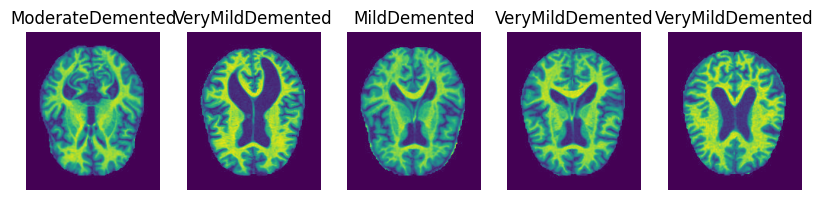

In [11]:
## get classes
classes = [d for d in os.listdir(train_data) if os.path.isdir(os.path.join(train_data,d))]
## selects 5 images at random
images =[]
labels=[]
for i in range (5):
  class_name=random.choice(classes)
  class_path=os.path.join(train_data,class_name)
  image_name=random.choice(os.listdir(class_path))
  images.append(os.path.join(class_path,image_name))
  labels.append(class_name)

#dsiplay of images
plt.figure(figsize=(10,10))
for i, img_path in enumerate(images):
  img=mpimg.imread(img_path)

  plt.subplot(1,5,i+1) # Creating 5 subplots in a 1x5 grid
  plt.imshow(img)
  plt.title(labels[i])
  plt.axis('off')

plt.show()

## Test Dataset

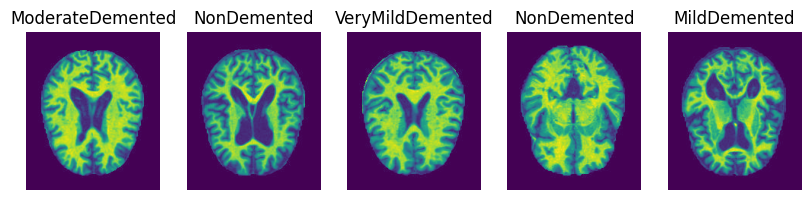

In [12]:
## get classes
classes = [d for d in os.listdir(test_data) if os.path.isdir(os.path.join(test_data,d))]
## selects 5 images at random
images =[]
labels=[]
for i in range (5):
  class_name=random.choice(classes)
  class_path=os.path.join(test_data,class_name)
  image_name=random.choice(os.listdir(class_path))
  images.append(os.path.join(class_path,image_name))
  labels.append(class_name)

#dsiplay of images
plt.figure(figsize=(10,10))
for i, img_path in enumerate(images):
  img=mpimg.imread(img_path)

  plt.subplot(1,5,i+1) # Creating 5 subplots in a 1x5 grid
  plt.imshow(img)
  plt.title(labels[i])
  plt.axis('off')

plt.show()

## Valid Dataset

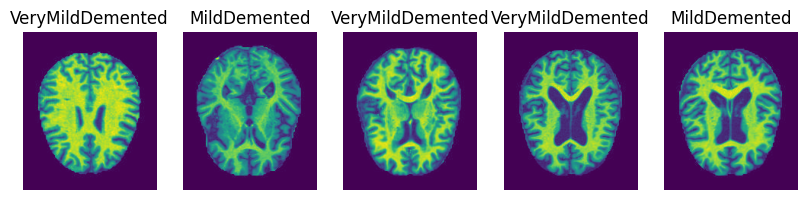

In [13]:
## get classes
classes = [d for d in os.listdir(valid_data) if os.path.isdir(os.path.join(valid_data,d))]
## selects 5 images at random
images =[]
labels=[]
for i in range (5):
  class_name=random.choice(classes)
  class_path=os.path.join(valid_data,class_name)
  image_name=random.choice(os.listdir(class_path))
  images.append(os.path.join(class_path,image_name))
  labels.append(class_name)

#dsiplay of images
plt.figure(figsize=(10,10))
for i, img_path in enumerate(images):
  img=mpimg.imread(img_path)

  plt.subplot(1,5,i+1) # Creating 5 subplots in a 1x5 grid
  plt.imshow(img)
  plt.title(labels[i])
  plt.axis('off')

plt.show()

## Exploratory Dataset Analysis (EDA)

Graphs for the Train Dataset

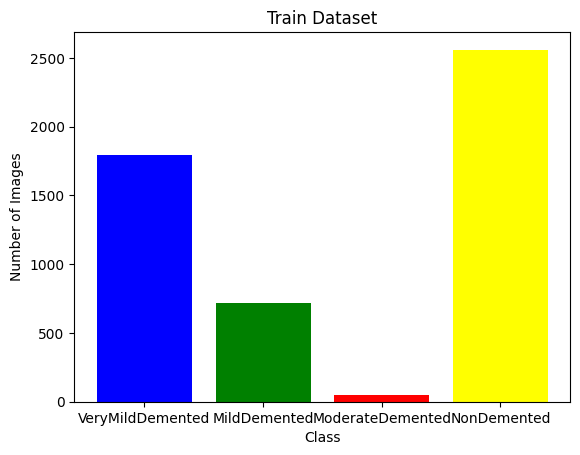

In [14]:
##  count image per class
train_counts= {class_name:len(os.listdir(os.path.join(train_data,class_name))) for class_name in classes}
## plot bar chart
plt.bar(train_counts.keys(), train_counts.values(), color=['blue','green','red','yellow'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Train Dataset')
plt.show()

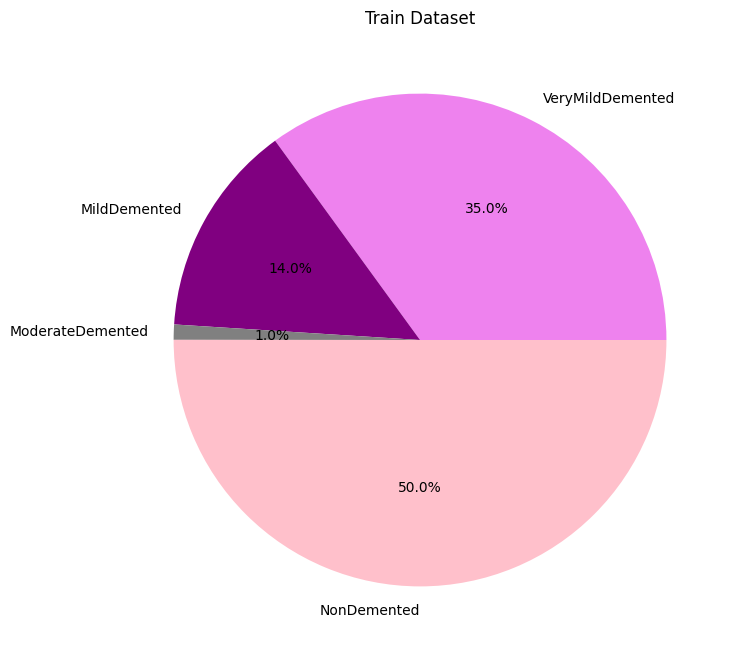

In [15]:
colors=['violet','purple','grey','pink']
# plot pie chart
plt.figure(figsize=(10,8))
plt.pie(train_counts.values(),labels=train_counts.keys(),colors=colors,autopct='%1.1f%%')
plt.title('Train Dataset')
plt.show()

Test Dataset

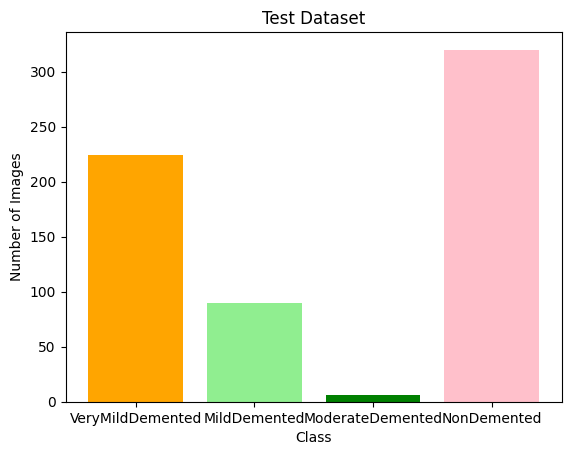

In [16]:
##  count image per class
test_counts= {class_name:len(os.listdir(os.path.join(test_data,class_name))) for class_name in classes}
## plot bar chart
plt.bar(test_counts.keys(), test_counts.values(), color=['orange','lightgreen','green','pink'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Test Dataset')
plt.show()

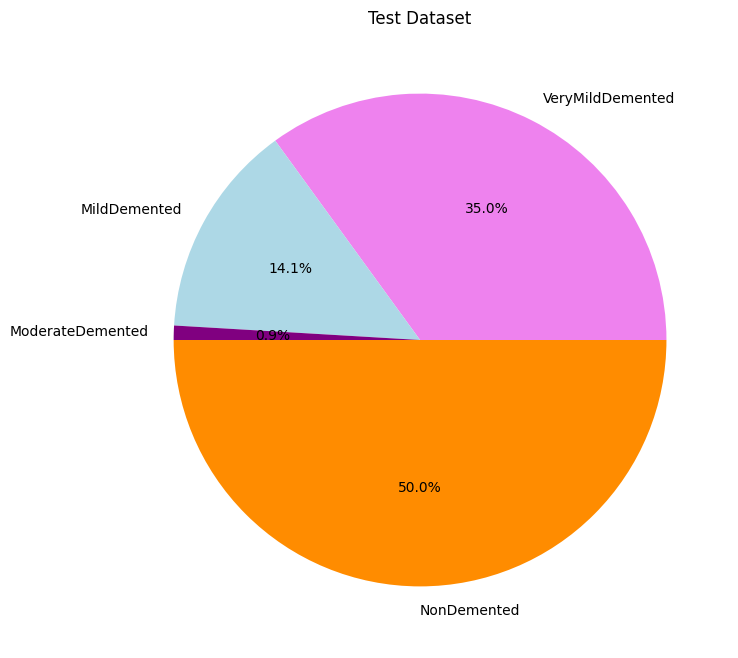

In [17]:
colors=['violet','lightblue','purple','darkorange']
# plot pie chart
plt.figure(figsize=(10,8))
plt.pie(test_counts.values(),labels=test_counts.keys(),colors=colors,autopct='%1.1f%%')
plt.title('Test Dataset')
plt.show()

Valid Dataset

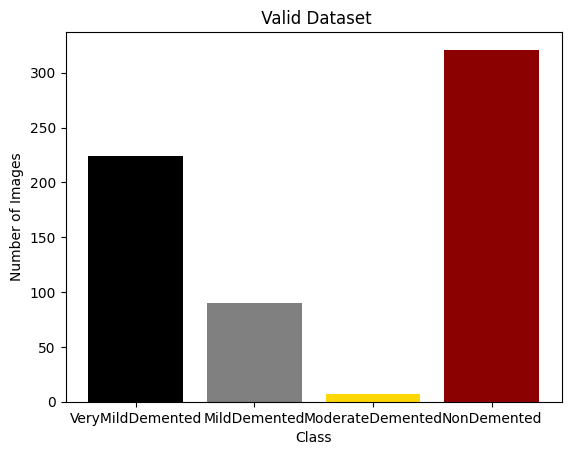

In [18]:
##  count image per class
valid_counts= {class_name:len(os.listdir(os.path.join(valid_data,class_name))) for class_name in classes}
## plot bar chart
plt.bar(valid_counts.keys(), valid_counts.values(), color=['black','grey','gold','darkred'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title(' Valid Dataset')
plt.show()

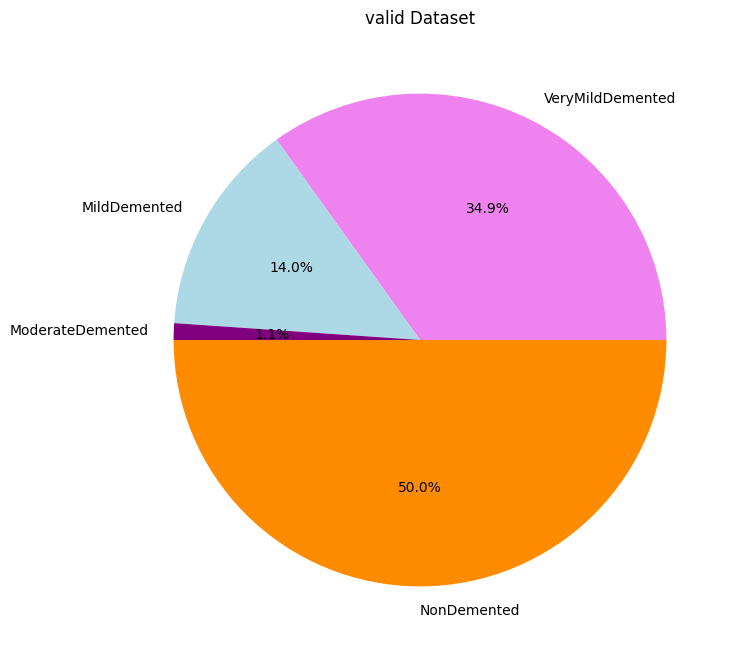

In [19]:
colors=['violet','lightblue','purple','darkorange']
# plot pie chart
plt.figure(figsize=(10,8))
plt.pie(valid_counts.values(),labels=valid_counts.keys(),colors=colors,autopct='%1.1f%%')
plt.title('valid Dataset')
plt.show()

## Models

In [20]:
IMG_SIZE=(150,150)
BATCH_SIZE=32

In [21]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_data,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
test_ds = keras.preprocessing.image_dataset_from_directory(
    test_data,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

valid_ds = keras.preprocessing.image_dataset_from_directory(
    valid_data,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
# Class names
class_names = train_ds.class_names
print(f"Classes: {class_names}")

Found 5119 files belonging to 4 classes.
Found 640 files belonging to 4 classes.
Found 642 files belonging to 4 classes.
Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


## KNN + MobileNet V2  Model

In [22]:
# Load MobileNetV2 model for feature extraction
base_model = keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False  # Freeze the base model

# Add custom layers for feature extraction
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(base_model.output)
feature_extractor_model = keras.Model(inputs=base_model.input, outputs=global_avg_pooling)

# Function to extract features from the dataset
def extract_features(dataset):
    features = []
    labels = []
    for images, labels_batch in dataset:
        feature_batch = feature_extractor_model(images)
        features.append(feature_batch.numpy())
        labels.append(labels_batch.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Extract features for training, validation, and testing datasets
train_features, train_labels = extract_features(train_ds)
valid_features, valid_labels = extract_features(valid_ds)
test_features, test_labels = extract_features(test_ds)

# Normalize the features (important for KNN)
train_features = train_features / np.linalg.norm(train_features, axis=1, keepdims=True)
valid_features = valid_features / np.linalg.norm(valid_features, axis=1, keepdims=True)
test_features = test_features / np.linalg.norm(test_features, axis=1, keepdims=True)

# Train the KNN model on the extracted features
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_features, train_labels)

# Evaluate the model
train_pred = knn.predict(train_features)
valid_pred = knn.predict(valid_features)
test_pred = knn.predict(test_features)

# Classification report



print("Test Performance:")
print(classification_report(test_labels, test_pred, target_names=train_ds.class_names))

<ipython-input-22-636d088a9f78>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Test Performance:
                  precision    recall  f1-score   support

    MildDemented       0.75      0.42      0.54        90
ModerateDemented       0.00      0.00      0.00         6
     NonDemented       0.77      0.80      0.78       320
VeryMildDemented       0.67      0.55      0.61       224

       micro avg       0.73      0.65      0.69       640
       macro avg       0.55      0.44      0.48       640
    weighted avg       0.72      0.65      0.68       640
     samples avg       0.65      0.65      0.65       640



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ROC Curve for KNN+Mobilenet v2 on the dataset

## Model Evaluation

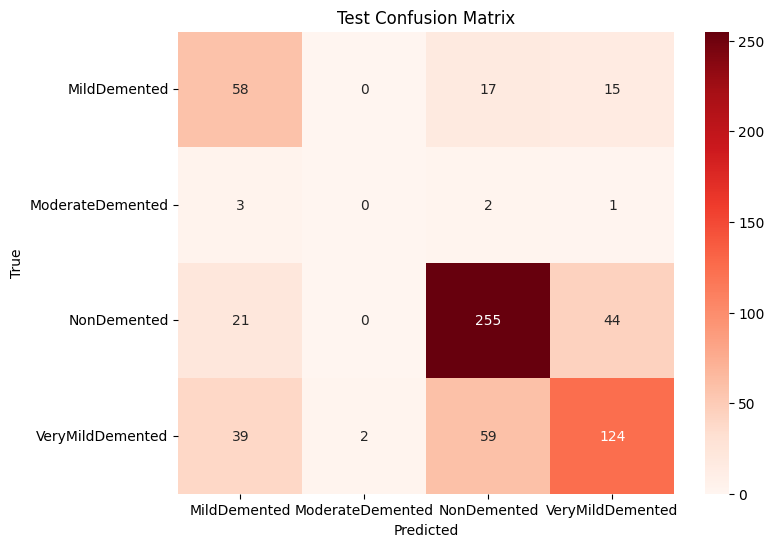

In [23]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    # Convert multilabel-indicator to single-label format
    y_true = np.argmax(y_true, axis=1)  # Get the index of the true class
    y_pred = np.argmax(y_pred, axis=1)  # Get the index of the predicted class

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
plot_confusion_matrix(test_labels, test_pred, train_ds.class_names, title='Test Confusion Matrix')

## Efficient Net bo

In [24]:
# ipython-input-10-c59cc43ec5a2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Input

# Load EfficientNetB0 without the top layers for feature extraction
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the model to prevent it from being trained
efficientnet_model.trainable = False

# Create the model
inputs = Input(shape=(150, 150, 3))

# Extract features with EfficientNetB0
efficientnet_output = efficientnet_model(inputs)

# Apply Global Average Pooling to reduce the dimensionality
gap = layers.GlobalAveragePooling2D()(efficientnet_output)

# Fully connected layer for classification
output = layers.Dense(4, activation='softmax')(gap)  # 10 is the number of classes, adjust as needed

# Create the final model
model1 = models.Model(inputs=inputs, outputs=output)

# Compile the model
# Change the loss function to 'categorical_crossentropy'
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model1.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 5, 5, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [25]:
history1= model1.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,
    batch_size=BATCH_SIZE
)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.5098 - loss: 1.0304 - val_accuracy: 0.5748 - val_loss: 0.9066
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.5694 - loss: 0.9145 - val_accuracy: 0.5981 - val_loss: 0.8936
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.5898 - loss: 0.8694 - val_accuracy: 0.6012 - val_loss: 0.8545
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.6170 - loss: 0.8381 - val_accuracy: 0.6168 - val_loss: 0.8340
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.6217 - loss: 0.8266 - val_accuracy: 0.6199 - val_loss: 0.8265
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.6238 - loss: 0.8083 - val_accuracy: 0.6262 - val_loss: 0.8149
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.6447 - loss: 0.7963 - val_accuracy: 0.6293 - val_loss: 0.8353
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.6420 - loss: 0.7875 - val_accu

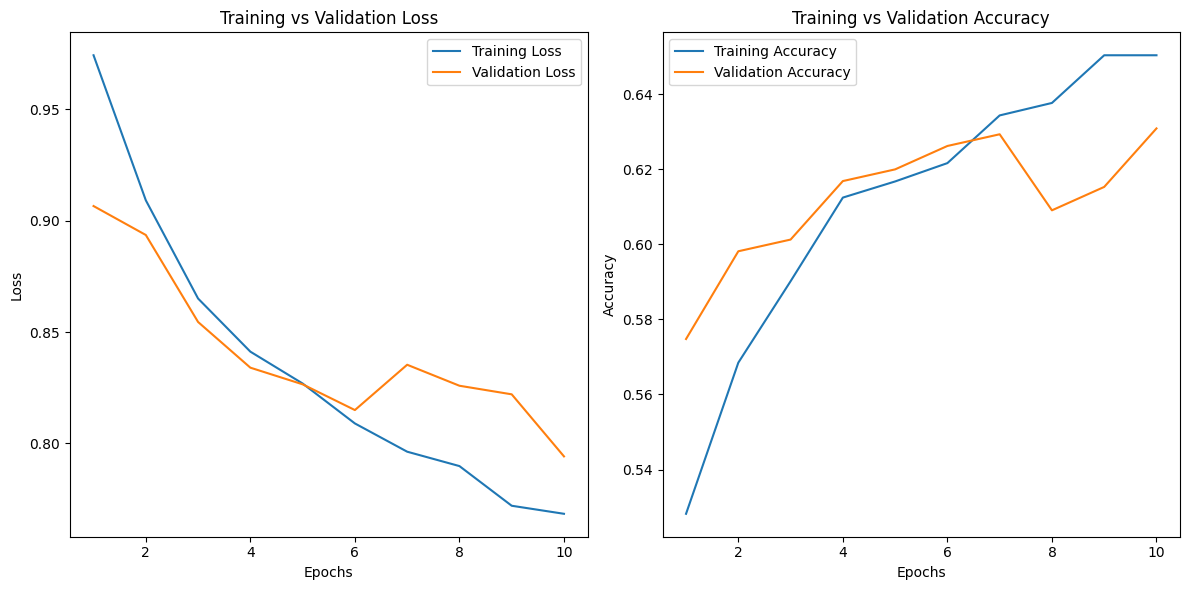

In [26]:
# Extract the training and validation accuracy and loss from history
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']
train_accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# Create ImageDataGenerator for preprocessing the images
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
# Evaluate the model on the validation and test datasets
valid_loss, valid_accuracy = model1.evaluate(valid_ds)
test_loss, test_accuracy = model1.evaluate(test_ds)

# Print the accuracy based on the test and validation datasets
print(f'Validation Accuracy: {valid_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 890ms/step - accuracy: 0.6167 - loss: 0.8184
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 983ms/step - accuracy: 0.6909 - loss: 0.7522
Validation Accuracy: 63.08%
Test Accuracy: 64.69%


Found 640 files belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
Classification Report:
                  precision    recall  f1-score   support

     NonDemented       0.58      0.23      0.33        90
VeryMildDemented       0.00      0.00      0.00        

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


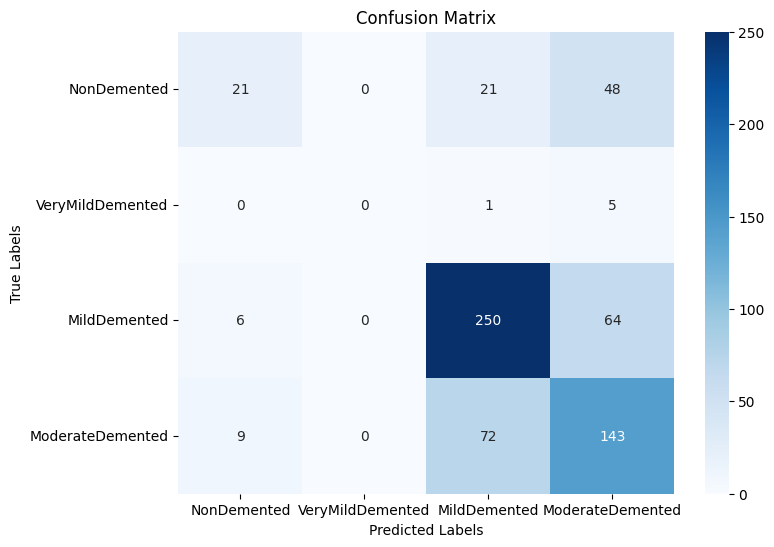

Accuracy from Classification Report: 64.69%


In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory  # Import the function

# Class names based on your dataset (as you provided)
class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

# **Define test_dir here (replace with your actual test directory path)**
test_dir = '/content/drive/MyDrive/Alzheimer_dataset/dir_split/test'

# Reset test_data generator to ensure we start from the beginning
test_data = image_dataset_from_directory(test_dir, batch_size=32, image_size=(150, 150),
                                         label_mode='categorical', shuffle=False, seed=42)

# Get the true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset
for image_batch, label_batch in test_data:
    # Predict class labels for the image batch
    predictions = model1.predict(image_batch)

    # Get the predicted class label (highest probability)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get the true class label (index of the class)
    true_classes = np.argmax(label_batch, axis=1)

    # Store the true and predicted labels
    true_labels.extend(true_classes)
    predicted_labels.extend(predicted_classes)

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Optionally, print accuracy to compare with the previously obtained accuracy
accuracy = np.sum(np.array(true_labels) == np.array(predicted_labels)) / len(true_labels)
print(f"Accuracy from Classification Report: {accuracy * 100:.2f}%")

## Hybrid Combination of Efficient Net B3 + ResNet 50

In [29]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Concatenate, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Image Size & Batch Size
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Define Input Shape
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
inputs = Input(shape=input_shape)

# Load EfficientNetB3 & ResNet50 (Pretrained)
efficientnet = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

efficientnet.trainable = False  # Freeze EfficientNet layers initially
resnet.trainable = False  # Freeze ResNet layers initially

# Extract Features
eff_net_output = GlobalAveragePooling2D()(efficientnet(inputs))
resnet_output = GlobalAveragePooling2D()(resnet(inputs))

# Concatenate Features with Batch Normalization
merged_features = Concatenate()([eff_net_output, resnet_output])
merged_features = BatchNormalization()(merged_features)

# Fully Connected Layers
x = Dense(512, activation='relu')(merged_features)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)  # Adjust number of classes accordingly

# Define Model
model = Model(inputs=inputs, outputs=outputs)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print Model Summary
model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb3            │ (None, 5, 5, 1536)     │     10,783,535 │ input_layer_3[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 5, 5, 2048)     │     23,587,712 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1536)           │              0 │ efficientnetb3[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 3584)           │              0 │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 3584)           │         14,336 │ concatenate[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │      1,835,520 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        131,328 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 4)              │          1,028 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 36,353,459 (138.68 MB)

 Trainable params: 1,975,044 (7.53 MB)

 Non-trainable params: 34,378,415 (131.14 MB)

Training cnn model

In [30]:
# Callbacks for Learning Rate Adjustment and Early Stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)

# Train Model
history = model.fit(train_ds, validation_data=valid_ds, epochs=30, batch_size=BATCH_SIZE, callbacks=[reduce_lr, early_stop])



Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 867s 5s/step - accuracy: 0.4707 - loss: 1.3929 - val_accuracy: 0.6090 - val_loss: 0.8765 - learning_rate: 1.0000e-04
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 834s 5s/step - accuracy: 0.5634 - loss: 1.0023 - val_accuracy: 0.6480 - val_loss: 0.7881 - learning_rate: 1.0000e-04
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 829s 5s/step - accuracy: 0.6275 - loss: 0.8680 - val_accuracy: 0.6745 - val_loss: 0.7165 - learning_rate: 1.0000e-04
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 870s 5s/step - accuracy: 0.6426 - loss: 0.8310 - val_accuracy: 0.7134 - val_loss: 0.6552 - learning_rate: 1.0000e-04
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 828s 5s/step - accuracy: 0.6781 - loss: 0.7619 - val_accuracy: 0.7383 - val_loss: 0.6278 - learning_rate: 1.0000e-04
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 832s 5s/step - accuracy: 0.6910 - loss: 0.6940 - val_accuracy: 0.7617 - val_loss: 0.5851 - learning_rate: 1.0000e-04
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 840s 5s/step - acc

# Model evaluation

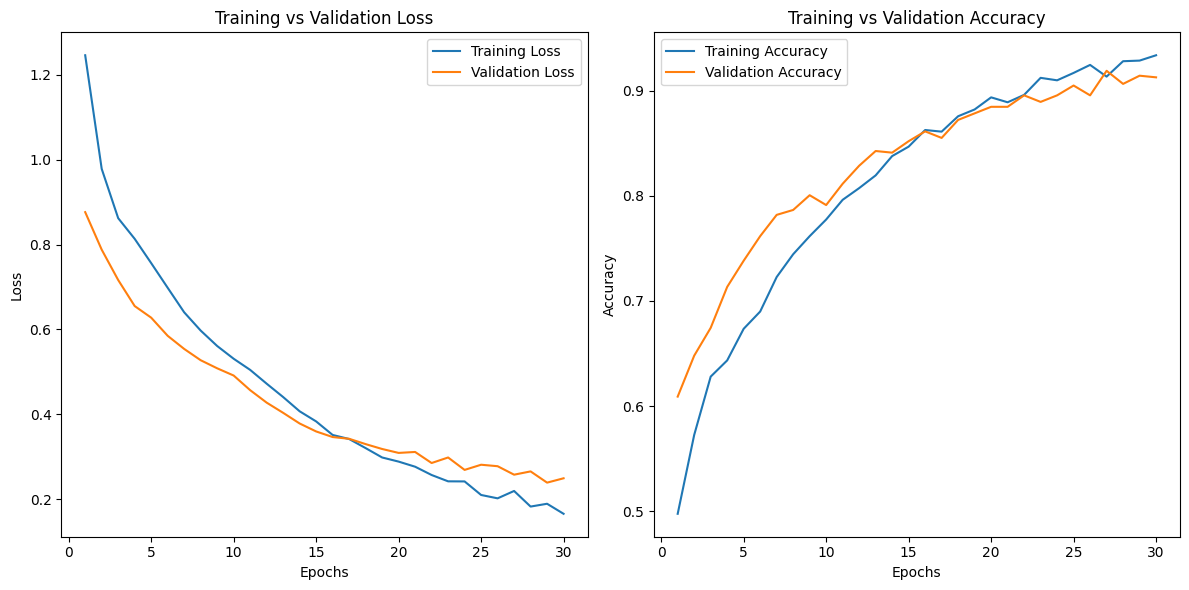

In [31]:
# Extract the training and validation accuracy and loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [32]:

# Evaluate the model on the validation and test datasets
valid_loss, valid_accuracy = model.evaluate(valid_ds)
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the accuracy based on the test and validation datasets
print(f'Validation Accuracy: {valid_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

21/21 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.9005 - loss: 0.2869
20/20 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.8899 - loss: 0.2858
Validation Accuracy: 91.90%
Test Accuracy: 88.91%


In [1]:
# Binarize the true labels for multi-class ROC
from sklearn.preprocessing import label_binarize #

In [2]:
import os
import cv2 as cv
import random
import numpy as np
import matplotlib.pyplot as plt

# Define base directory for the new dataset
brain_base_dir = '/content/drive/MyDrive/Alzheimer_dataset/dir'

# Folder names for Brain dataset (Class Names)
brain_folders = ['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']

# Combine the Brain folder names into a single labels list
labels = brain_folders

# Define the image size for model input
image_size = (150,150)  # Adjust according to your model input size

# Function to allow user input and display images and accuracy
def user_input_and_accuracy(labels, model):
    correct_predictions = 0
    total_predictions = 0

    while True:
        # Get user input
        user_input = input(f'Enter a label ({", ".join(labels)}) or "*" to quit: ').strip()
        if user_input == '*':
            break
        if user_input not in labels:
            print("Invalid input. Please enter a valid label.")
            continue

        # Select the base directory and label folder based on user input
        label_folder = os.path.join(brain_base_dir, user_input)
        if not os.path.exists(label_folder):
            print("Invalid label folder.")
            continue

        # Select a random image with the user input label
        img_name = random.choice(os.listdir(label_folder))
        img_path = os.path.join(label_folder, img_name)
        img = cv.imread(img_path)
        img_resized = cv.resize(img, image_size)
        img_resized = np.expand_dims(img_resized, axis=0) / 255.0  # Rescale

        # Predict the image using the trained model
        prediction = model.predict(img_resized)
        predicted_label = labels[np.argmax(prediction)]
        prediction_percentage = prediction[0][np.argmax(prediction)] * 100

        # Display the image
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Prediction Percentage: {test_accuracy * 100:.2f}%')
        plt.show()

        # Determine if the user's input is correct
        correct = user_input == predicted_label
        total_predictions += 1
        if correct:
            correct_predictions += 1

        # Calculate and display accuracy
        print(f"Actual label: {user_input}")
        print(f"Predicted label: {predicted_label}")
        print(f'prediction percentage: {test_accuracy * 100:.2f}%')

        input("Press Enter to continue...")

        # Check if accuracy is below 80%
        if accuracy < 80:
            print("Accuracy is below 80%. Please try again.")
            break  # Exit loop if accuracy falls below 80%

# Assuming the model is already loaded and available, call the function
user_input_and_accuracy(labels, model)


NameError: name 'model' is not defined